In [1]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:
import csv
from quantumGraphSolverFVM import QuantumGraphSolverFVM
import graph

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN

# Using autokeras

In [4]:
from sklearn.model_selection import train_test_split
from autokeras import StructuredDataRegressor

In [29]:
xth_frame = 5
# Time discretization of PINN
N_b = 200
# Time discretization of FVM
nt = N_b * xth_frame
# Spatial discretization of PINN
N_0 = 200
# Spatial discretization of FVM
nx = N_0 + 1

graph_test = graph.Example0()
graph_test.buildGraph()

fvm_solver = QuantumGraphSolverFVM(graph_test)
u = fvm_solver.solve(nx=nx, nt=nt)

In [30]:
def write_csv(fvm, nx, j=0):
        u = fvm.u
        he = 1.0 / nx
        
        with open('FVM_results.csv', 'w', newline='') as f:
            thewriter = csv.writer(f)
            for i in range(np.shape(u)[0]-3):
                for j in range(np.shape(u)[1]):
                    thewriter.writerow([i * he, j * 1./100, u[i,j]])
                    # the right input parameters (x, t) are needed

In [31]:
write_csv(fvm_solver, nx)

In [32]:
dataset = np.loadtxt('FVM_results.csv', delimiter=',')
x_csv = tf.convert_to_tensor(dataset[::1000,0])
t_csv = tf.convert_to_tensor(dataset[:1000,1])
u_csv = tf.convert_to_tensor(dataset[:,2])
u_csv_matrix = tf.reshape(u_csv, (198,1000))
xt_csv = tf.convert_to_tensor(dataset[:,0:2])

In [33]:
xt_train, xt_test, u_train, u_test = train_test_split(xt_csv.numpy(), u_csv.numpy(), test_size=0.2, random_state=1)

search = StructuredDataRegressor()

search.fit(x=xt_train, y=u_train, verbose=0)

mae, _ = search.evaluate(xt_test, u_test, verbose=0)
print('MAE: %.3f' % mae)
# use the model to make a prediction
# X_new = asarray([[108]]).astype('float32')
# yhat = search.predict(X_new)
# print('Predicted: %.3f' % yhat[0])
# get the best performing model
model = search.export_model()
# summarize the loaded model
model.summary()
# save the best performing model to file
model.save('model_insurance')

INFO:tensorflow:Reloading Oracle from existing project .\structured_data_regressor\oracle.json
INFO:tensorflow:Reloading Tuner from .\structured_data_regressor\tuner0.json


C:\Users\rieme\anaconda3\lib\site-packages\keras_tuner\engine\metrics_tracking.py:85: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


INFO:tensorflow:Oracle triggered exit
Epoch 1/35
4950/4950 [==============================] - 6s 1ms/step - loss: 662.3885 - mean_squared_error: 662.3885
Epoch 2/35
4950/4950 [==============================] - 6s 1ms/step - loss: 222.7666 - mean_squared_error: 222.7666
Epoch 3/35
4950/4950 [==============================] - 6s 1ms/step - loss: 59.2078 - mean_squared_error: 59.2078
Epoch 4/35
4950/4950 [==============================] - 6s 1ms/step - loss: 10.4392 - mean_squared_error: 10.4392
Epoch 5/35
4950/4950 [==============================] - 7s 1ms/step - loss: 1.0875 - mean_squared_error: 1.0875
Epoch 6/35
4950/4950 [==============================] - 6s 1ms/step - loss: 0.1381 - mean_squared_error: 0.1381
Epoch 7/35
4950/4950 [==============================] - 6s 1ms/step - loss: 0.0627 - mean_squared_error: 0.0627
Epoch 8/35
4950/4950 [==============================] - 7s 1ms/step - loss: 0.0391 - mean_squared_error: 0.0391
Epoch 9/35
4950/4950 [==============================] 

In [25]:
xt_train, xt_test, u_train, u_test = train_test_split(xt_csv.numpy(), u_csv.numpy(), test_size=0.2)
model.fit(xt_train, u_train, epochs=3, batch_size=100)

Epoch 1/3
1584/1584 [==============================] - 2s 1ms/step - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 2/3
1584/1584 [==============================] - 2s 1ms/step - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 3/3
1584/1584 [==============================] - 2s 1ms/step - loss: 0.0178 - mean_squared_error: 0.0178


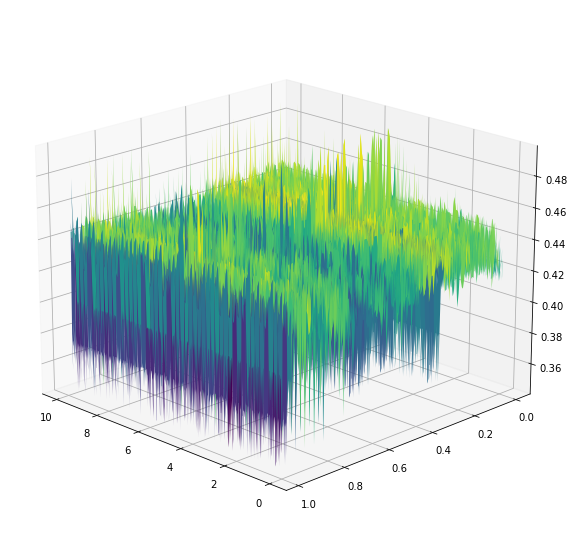

In [36]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

T, X = tf.meshgrid(t_csv, x_csv)
XT = tf.stack([tf.reshape(X,-1), tf.reshape(T,-1)],axis=1)
U = model(XT)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

## Set up class GraphPINNs

In [ ]:
from tensorflow.keras import backend as Kback
def my_act(x):
    e1 = Kback.exp(x)
    e2 = Kback.exp(-x)
    return Kback.log(e1+e2)

In [ ]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=4,
                 num_neurons_per_layer=20,
                 activation='sigmoid',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        self.out = tf.keras.layers.Dense(output_dim, activation='sigmoid')
        
    def call(self, X):
        """Forward-pass through neural network."""
        
        #Z = self.scale(X)
        Z = X
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

In [ ]:
# Define model architecture
class PINN_ResNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 ResNetLayers=3,
                 ResNetNeurons=16,
                 ResNetStepsize=1.0,
                 ResNetActivation='softplus',
                 **kwargs):
        
        super(PINN_ResNet, self).__init__(**kwargs)
        
        #RNact = tf.keras.activations.get(ResNetActivation)
        #RNact = my_act
        RNact = tf.keras.activations.get('sigmoid')

        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = 1
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Output layer
        #self.out = tf.keras.layers.Dense(1, activation='sigmoid')

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi
        #return self.out(Phi)

In [ ]:
# Define model architecture
class PINN_CNN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(15, 1, activation='sigmoid'))
#         self.model.add(tf.keras.layers.MaxPool1D(1))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(1, 1, activation='sigmoid'))
        
    def call(self, X):
        Z = self.model(tf.reshape(X, (X.shape[0], 1, 2)))
            
        return tf.reshape(Z, (X.shape[0], 1))

In [ ]:
# Define model architecture
# class PINN_ResNet_CNN(tf.keras.Model):
#     """ Set basic architecture of the PINN model."""

#     def __init__(self, lb, ub,
#                  ResNetLayers=3,
#                  ResNetNeurons=16,
#                  ResNetStepsize=1.0,
#                  ResNetActivation='softplus',
#                  **kwargs):
        
#         super(PINN_ResNet_CNN, self).__init__(**kwargs)
        
#         #RNact = tf.keras.activations.get(ResNetActivation)
#         #RNact = my_act
#         RNact = tf.keras.activations.get('sigmoid')

        
#         self.ResNetLayers = ResNetLayers
#         self.ResNetStepsize = ResNetStepsize

#         self.ResNet = tf.keras.models.Sequential()
#         self.ResNet.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
#         self.ResNet.add(tf.keras.layers.AveragePooling1D(1))
#         self.ResNet.add(tf.keras.layers.Conv1D(16, 1, activation='sigmoid'))
        
        
#         self.wb = tf.keras.layers.Dense(1)
#         self.A = tf.keras.layers.Dense(2, use_bias=False)
#         self.c = tf.keras.layers.Dense(1, use_bias=False)
        
#         #self.num_hidden_layers = num_hidden_layers
#         self.input_dim = lb.shape[0]
#         self.output_dim = 1
#         self.lb = lb
#         self.ub = ub

#         # Define NN architecture
        
#         # Output layer
#         #self.out = tf.keras.layers.Dense(1, activation='sigmoid')
        
    
#     def apply(self, X):
#         Z = self.ResNet(tf.reshape(X, (X.shape[0], 1, 2)))
            
#         return tf.reshape(Z, (X.shape[0], 1))
        
#     def call(self, input_tensor, training=False):
#         """Forward-pass through neural network."""
#         N = self.apply(input_tensor)
#         for i in range(1, self.ResNetLayers):
#             N = N + self.ResNetStepsize * self.apply(N)
#         Phi = self.wb(N, training=training)
#         #print(input_tensor)
#         As = self.A(input_tensor, training=training)
#         #print(As)
#         sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
#         #print(sAs)
#         Phi += .5 * sAs
#         #print(Phi.shape)
#         Phi += self.c(input_tensor, training=training)
            
#         return Phi
#         #return self.out(Phi)

In [ ]:
# Define model architecture
class PINN_LSTM(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = Sequential()
        self.model.add(LSTM(32, activation='sigmoid', return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(32, activation='sigmoid'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(16, activation='sigmoid'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def call(self, X):
        Z = tf.reshape(X, (X.shape[0], 1, 2))
        return self.model(Z)

In [ ]:
# Define model architecture
class PINN_RNN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = Sequential()
        self.model.add(SimpleRNN(32, activation='sigmoid', return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(SimpleRNN(32, activation='sigmoid'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(16, activation='sigmoid'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def call(self, X):
        Z = tf.reshape(X, (X.shape[0], 1, 2))
        return self.model(Z)

In [ ]:
DTYPE = 'float64'
# Lower bounds
lb = tf.constant([0, 0], dtype=DTYPE)

# Upper bounds
ub = tf.constant([10, 1], dtype=DTYPE)

pinn = PINN_ResNet(lb=lb, ub=ub)
pinn(tf.constant([[1., 1.],[1., 0.], [0., 1.]]))

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[1.09760104],
       [2.88694644],
       [1.66479618]])>

In [ ]:
tmp=pinn.ResNet[0]
tmp.weights[0]

<tf.Variable 'pinn__res_net_2/dense_12/kernel:0' shape=(2, 16) dtype=float64, numpy=
array([[ 0.01544747,  0.51130683, -0.14741855,  0.51408335, -0.30229583,
         0.05048282,  0.32055911, -0.03498853, -0.16946917, -0.02240495,
         0.15878493, -0.43525364, -0.03060061,  0.26979691,  0.12923092,
         0.2585142 ],
       [-0.10866184,  0.02470017,  0.3462168 , -0.42445705, -0.50862698,
         0.36773763,  0.06403714,  0.43821329,  0.07034578, -0.50572959,
        -0.53980295, -0.12832639, -0.29093499, -0.47776907,  0.51233417,
         0.56839473]])>

In this notebook, we rely on the package [NetworkX](https://networkx.org/).
An alternative approach would be to employ [igraph](https://igraph.org/), which seems to be more lightweight.

Next, we set up the class for a graph PINN which takes either an adjacency matrix $A$ or a `MultiDiGraph` as input `inp` to define the network as well as the Dirichlet data as a list of pairs $(i, u_i)_{i=1}^{n_D}$ corresponding to $u(v_i) = u_i$.
*Notes*:
- we define our graph as a `MultiDiGraph` since graphs imported from [OpenStreetMap](https://www.openstreetmap.de/) obey this format.

In [ ]:
import networkx as netx

class GraphPINN():
    
    def __init__(self, inp, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, Type = 'FNN'):
        
        if isinstance(inp, netx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = netx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = netx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        self.type = Type
        
        # Setup list of neural networks
        self._setupNNs()
        
        # Determine graph layout if necessary
        self.pos = netx.kamada_kawai_layout(self.G)
        
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        if self.type == 'ResNet':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_ResNet(lb=self.lb, ub=self.ub))
        elif self.type == 'FNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN(lb=self.lb, ub=self.ub))
        elif self.type == 'CNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_CNN(lb=self.lb, ub=self.ub))
        elif self.type == 'ResNetCNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_ResNet_CNN(lb=self.lb, ub=self.ub))
        elif self.type == 'LSTM':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_LSTM(lb=self.lb, ub=self.ub))
        elif self.type == 'RNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_RNN(lb=self.lb, ub=self.ub))
        else:
            print('No valid type passed! FNN is used.')
            for i, e in enumerate(self.E):
                self.NNs.append(PINN(lb=self.lb, ub=self.ub))
        
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))
    
    def plotGraph(self, **kwargs):

        netx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)

### Example

First, we define a network which is determined by its
adjacency matrix $A \in \mathbb{R}_+^{n_v \times n_v}$ with $n_v$ the number of vertices.
Note that this matrix is not symmetric, as it belongs to a *directed* graph.
Here, an entry $a_{i,j} > 0$ indicates that there is an edge starting in vertex $i$ and ending in vertex $j$ with length $a_{i,j}$.

In [ ]:
#DTYPE = 'float32'
DTYPE = 'float64'
adj = 2
tf.keras.backend.set_floatx(DTYPE)
time_dependent = False

# Specify adjacency matrix
if adj == 1:
    A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.0])
    dirichletBeta = np.array([0.0, 0.5])
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    
elif adj == 2:
    A = tf.constant([[0, 1],
                 [0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 1])
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
        #return .5 +(.5*-tf.sin(x*np.pi))
    
elif adj == 3:
    A = tf.constant([[0, 1, 0],
                     [0, 0, 1],
                     [0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 0.5
    
    eps = .01

    dirichletNodes = np.array([0, 2])
    
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    #time_dependent = True
    #dirichletAlpha = np.array([lambda x: 0.7*x/10, lambda x: 0.0*x])
    #dirichletBeta = np.array([lambda x: 0.0, lambda x: 0.8*x/10])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 4:
    A = tf.constant([[0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 2, 3])
    dirichletAlpha = np.array([0.7, 0.0, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.0])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 0:
    A = tf.constant([[0, 0, 1,0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 3])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.8, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.])
                              
    
    eps = 1e-6
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
elif adj == 5:
    A = tf.constant([[0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    dirichletNodes = np.array([0, 1, 4, 5])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.9, 0.3, 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.8, 0.1])
                              
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.


# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

Initialized 1 neural nets.
Vin: [[], [0]]
Vout: [[0], []]


{0: array([1.00000000e+00, 4.37113883e-08]),
 1: array([-1.00000000e+00, -4.37113883e-08])}

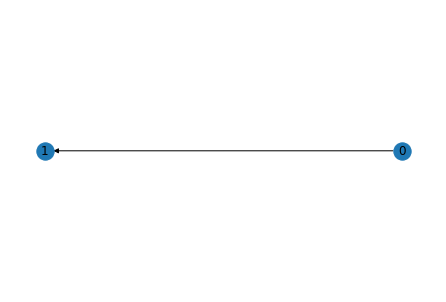

In [ ]:
%matplotlib inline

gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'ResNet')
gPINN.plotGraph()
print('Vin:', gPINN.Vin)
print('Vout:', gPINN.Vout)
gPINN.E
gPINN.pos

Draw collocation points uniformly or take them equidistantly distributed.

In [ ]:
mode = 'deterministic'
mode = 'uniform'

N_0 = 1000
N_b = 1000
N_r = 4000

# Set random seed for reproducible results
tf.random.set_seed(0)

def drawCollocationPoints(N_0, N_b, N_r):
    X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)
    
    # Draw uniform sample points for initial boundary data
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    
    # Boundary data
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
    x_l = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
    X_l = tf.concat([t_b, x_l], axis=1)
    
    x_u = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
    X_u = tf.concat([t_b, x_u], axis=1)
    
    X_b = tf.concat([X_l, X_u], axis=0)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    # X_data = tf.concat([X_0, X_b, X_r], axis=0)
    return X_r, X_0, X_l, X_u

if mode == 'deterministic':

    # Uniform distributed collocation points
    t_r = tf.linspace(lb[0], ub[0], N_0+1)
    x_r = tf.linspace(lb[1], ub[1], N_b+1)
    tt, xx = tf.meshgrid(t_r,x_r)
    X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

elif mode == 'uniform':
    
    X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #X_data = tf.concat([X_0, X_b, X_r], axis=0)

Draw collocation points.

Text(0, 0.5, 'x')

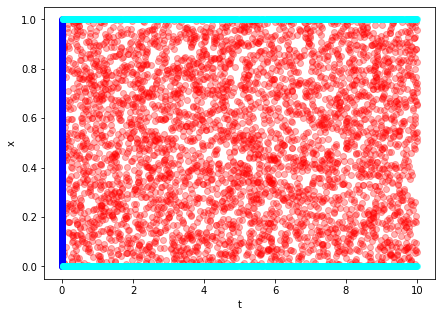

In [ ]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
ax.scatter(X_0[:,0].numpy(), X_0[:,1].numpy(), color='blue', alpha=0.5)
ax.scatter(X_u[:,0].numpy(), X_u[:,1].numpy(), color='cyan', alpha=0.5)
ax.scatter(X_l[:,0].numpy(), X_l[:,1].numpy(), color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('x')

## Set up class for time-dependent equations

We have to handle different kinds of boundary and vertex conditions:
- all inner vertices: Kirchhoff-Neumann conditon
- initial time conditions on all edges
- Dirichlet conditions on selected vertices as long as it is an inflowing node

In [ ]:
from time import time

class graphPINNSolver(object):
    def __init__(self, graphPINN, Xr, X0, Xl, Xu):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne
        
        self._updateData(Xr, X0, Xl, Xu)
        
        

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(self.ne):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]], dtype=DTYPE))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)
        
        # Setup auxiliary variables for vertex values to ensure continuity
        self._setupVertexVariables()
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append([self.vertexVals[i]])
        
        self.nvar = len(self.trainable_variables)
        
    def _updateData(self, Xr, X0, Xl, Xu):
        self.Xr = Xr
        self.X0 = X0
        self.Xl = Xl
        self.Xu = Xu
        
        self.nr = Xr.shape[0]
        self.n0 = X0.shape[0]
        self.nb = Xl.shape[0]

    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for _ in self.graphPINN.innerVertices:
            self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(self.nb,), dtype=DTYPE), trainable=True))

    def _fvals0(self, t, x):

        # Initialize lists for values and derivatives
        u = []
        tx = tf.stack([t, x], axis=1)
        for i in range(self.ne):
            u.append(self.graphPINN.NNs[i](tx)[:,0])

        return u
    
    def _fvals1(self, t, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        
        for i in range(self.ne):
            
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(t)
                tape.watch(x)

                tx = tf.stack([t, x], axis=1)

                # Compute current values u(t,x)
                u.append(self.graphPINN.NNs[i](tx)[:, 0])
            ut.append(tape.gradient(u[i], t))
            ux.append(tape.gradient(u[i], x))
            
            del tape
                
        return u, ut, ux
    
    def _fvals2(self, t, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        uxx = []
        
        for i in range(self.ne):
            
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(t)
                tape.watch(x)

                tx = tf.stack([t, x], axis=1)

                # Compute current values u(t,x)
                u.append(self.graphPINN.NNs[i](tx)[:,0])
                ux.append(tape.gradient(u[i], x))
                
            ut.append(tape.gradient(u[i], t))
            uxx.append(tape.gradient(ux[i], x))
            
            del tape
                
        return u, ut, ux, uxx
    
    def determine_losses(self):
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        ###################################
        ### Residual loss for all edges ###
        ###################################
        u, ut, ux, uxx = self._fvals2(self.Xr[:,0], self.Xr[:,1])
        
        loss_res = 0
        for i in range(self.ne):
            res_e = pde(u[i], ut[i], ux[i], uxx[i])
            loss_res += mse(res_e)
        
        
        ###################################
        ### Initial conds for all edges ###
        ###################################
        
        u = self._fvals0(self.X0[:,0], self.X0[:,1])
        
        loss_init = 0
        for i in range(self.ne):
            res_e = u[i] - initial_cond(self.X0[:,1])
            loss_init += mse(res_e)
        
        ###################################
        ###   Continuity in vertices    ###
        ###################################
        
        ul, ult, ulx = self._fvals1(self.Xl[:,0], self.Xl[:,1])
        uu, uut, uux = self._fvals1(self.Xu[:,0], self.Xu[:,1])
        loss_cont = 0
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            
            for j in self.graphPINN.Vin[v]:
                val = uu[j] - self.vertexVals[i]
                loss_cont += mse(val)

            for j in self.graphPINN.Vout[v]:
                val = ul[j] - self.vertexVals[i]
                loss_cont += mse(val)

        #####################################
        ### Kirchhoff-Neumann in vertices ###
        #####################################
        
        # Kirchhoff-Neumann condition in center nodes
        loss_KN = 0
        for i in self.graphPINN.innerVertices:
            
            val = 0
            print('Kirchhoff-Neumann in node ', i)
            for j in self.graphPINN.Vin[i]:
                print('incoming edge:', j)
                val += flux(uu[j], uux[j])
                
            for j in self.graphPINN.Vout[i]:
                print('outgoing edge:', j)
                val -= flux(ul[j], ulx[j])
            loss_KN += mse(val)
        
        #####################################
        ###      Inflow/Outflow conds     ###
        #####################################
            
        loss_D = 0
        for i,v in enumerate(self.graphPINN.dirichletNodes):
            
            if time_dependent:
                alpha = self.graphPINN.dirichletAlpha[i](self.Xl[:,0])
                beta = self.graphPINN.dirichletBeta[i](self.Xl[:,0])
            else:
                alpha = self.graphPINN.dirichletAlpha[i]
                beta = self.graphPINN.dirichletBeta[i]
            
            print('\nin node ', v, 'alpha ', alpha, 'beta ', beta)
            val = 0
            for j in self.graphPINN.Vin[v]:
                print('outflow: ', j)
                val += flux(uu[j], uux[j]) \
                    - beta * (uu[j])
                #loss_D += mse(val)

            for j in self.graphPINN.Vout[v]:
                print('inflow: ', j)
                val += -flux(ul[j], ulx[j]) \
                    + alpha * (1-ul[j])
                #loss_D += mse(val)
            loss_D += mse(val)
        print(loss_res)
        print(loss_init)
        print(loss_cont)
        print(loss_KN)
        print(loss_D)
        return loss_res, loss_init, loss_cont, loss_KN, loss_D
    
    def loss_fn(self):
        
        loss_res, loss_init, loss_cont, loss_KN, loss_D = self.determine_losses()
        
        loss = loss_res + loss_init + loss_cont + loss_KN + loss_D

        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

# Feed Forward Neural Net

In [ ]:
gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'FNN')
N_0 = 1000
N_b = 1000
N_r = 4000
solver = graphPINNSolver(gPINN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 1 neural nets.


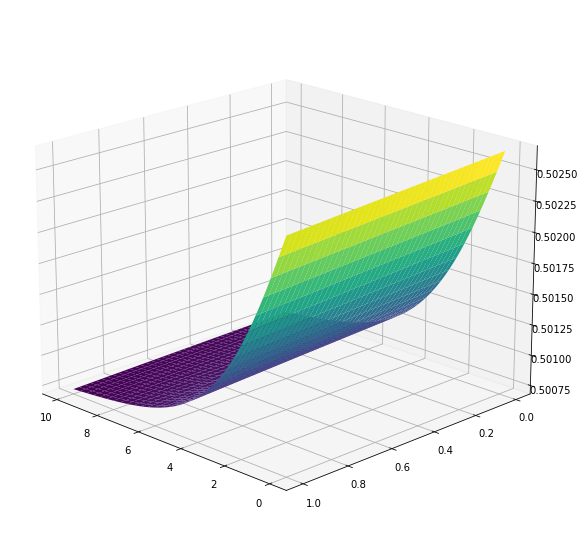

In [ ]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


In [ ]:
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=2001)
#for i in range(20):
    # WARNING: Update of collocation points currently not supported
    # Vertex values are fixed for coordinates at boundary!
    #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #solver._updateData(X_r, X_0, X_l, X_u)
    #solver.solve_with_TFoptimizer(optim, N=301)


Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  2.85197121e-01   3.97
00020  1.71265972e-01   4.82
00040  1.33935334e-01   5.73
00060  5.88532833e-02   6.55
00080  4.31483789e-02   7.32
00100  3.73646658e-02   8.06
00120  3.45563560e-02   8.80
00140  2.69468206e-02   9.55
00160  1.23104936e-02   10.30
00180  1.07471866e-02   11.05
00200  9.62377231e-03   11.79
00220  8.88283903e-03   12.51
00240  8.34435699e-03   13.23
00260  7.94047527e-03   13.95
00280  7.61283674e-03   14.68
00300  7.32891602e-03   15.29
00320  7.06802358e-03   15.88
00340  6.81409909e-03   16.73
00360  6.55947976e-03   17.61
00380  6.30254904e-03   18.55
00400  6.04529631e-03   19.39
00420  5.79213671e-03   20.25
00440  5.55068638e-03   21.05
00460  5.32

In [ ]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  2.05307444e-03   0.63
02040  2.03918292e-03   1.31
02060  2.01570011e-03   2.11
02080  2.00483322e-03   2.84
02100  1.99161272e-03   3.57
02120  1.97496726e-03   4.35
02140  1.96311839e-03   5.11
02160  1.94987535e-03   5.67
02180  1.93826596e-03   6.30
02200  1.92353315e-03   7.06
02220  1.91590409e-03   8.07
02240  1.91257863e-03   9.27
02260  1.90003485e-03   10.45
02280  1.89264073e-03   11.41
02300  1.88822760e-03   12.19
02320  1.88472827e-03   13.05
02340  1.87684481e-03   14.12
02360  1.87399084e-03   14.91
02380  1.86873553e-03   15.80
02400  1.86194734e-03   16.70
02420  1.85537162e-03   17.62
02440  1.84933004e-03   18.95
02460  1.82984399e-03   19.98
02480  1.80839191e-03   20.94
02500  1.75431156e-03   22.11
02520  1.70903260e-03   23.10
02540  1.61323770e-03   24.16
02560  1.39810252e-03   25.00
02580  1.12995390e-03   25.93
02600  9.00836217e-04   26.96
02620  6.91251873e-04   

In [ ]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(1, figsize=(10, 10))
#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = solver.graphPINN.pos
    for i, e in enumerate(solver.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1])
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = solver.graphPINN.NNs[i](tf.concat([t0,xspace],axis=1))
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(12, 135)
    return u

j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

interactive(children=(IntSlider(value=0, description='j', max=60), Output()), _dom_classes=('widget-interact',…

<Figure size 720x720 with 0 Axes>

Surface plot of function values on a single edge.

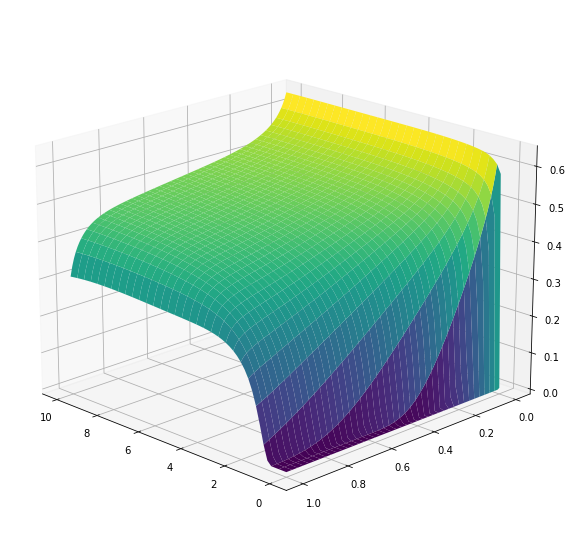

In [ ]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


# Residual Neural Network

In [ ]:
gPINN_ResNet = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub)
N_0 = 1000
N_b = 1000
N_r = 4000
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
solver_ResNet = graphPINNSolver(gPINN_ResNet, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

Initialized 1 neural nets.


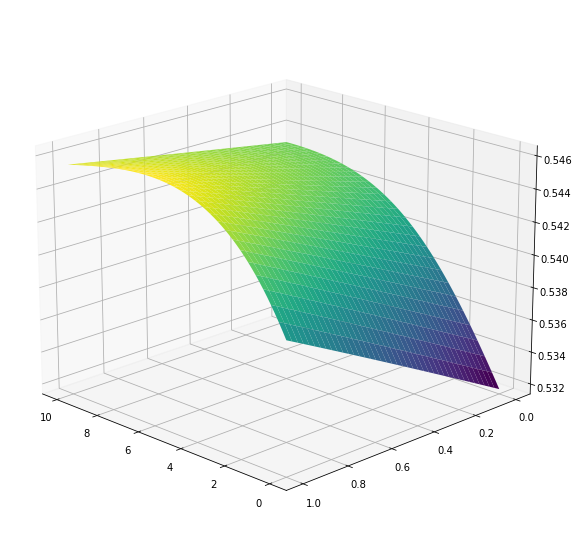

In [ ]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_ResNet.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [ ]:
# Solve with Adam optimizer
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_ResNet.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  3.27632123e-01   0.62
00020  6.95327311e-02   1.03
00040  4.82013527e-02   1.43
00060  2.70233579e-02   1.83
00080  1.38963726e-02   2.26
00100  1.19745180e-02   2.75
00120  1.10278543e-02   3.08
00140  1.02650434e-02   3.46
00160  9.66910748e-03   3.81
00180  9.19652702e-03   4.18
00200  8.78989369e-03   4.53
00220  8.43133841e-03   4.93
00240  8.10771543e-03   5.43
00260  7.81003686e-03   6.01
00280  7.53172584e-03   6.49
00300  7.26818870e-03   6.99
00320  7.01656784e-03   7.52
00340  6.77548865e-03   7.99
00360  6.54468057e-03   8.46
00380  6.32452229e-03   8.93
00400  6.11556751e-03   9.41
00420  5.91816750e-03   9.90
00440  5.73228925e-03   10.37
00460  5.55751915e-03   1

In [ ]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver_ResNet.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver_ResNet.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  2.07110537e-03   0.52
02040  2.01648907e-03   0.96
02060  1.98427555e-03   1.44
02080  1.96891960e-03   1.97
02100  1.95435840e-03   2.55
02120  1.94175578e-03   3.10
02140  1.93329689e-03   3.61
02160  1.92643784e-03   4.23
02180  1.91474651e-03   4.89
02200  1.90727605e-03   5.42
02220  1.90315359e-03   5.96
02240  1.90015373e-03   6.49
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


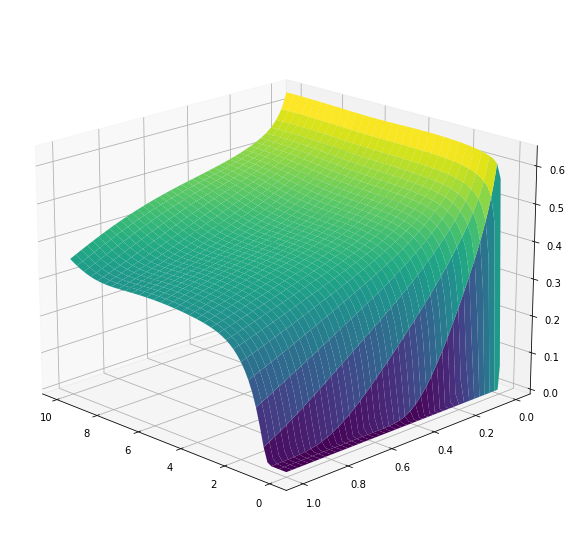

In [ ]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_ResNet.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# CNN

In [ ]:
gPINN_CNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'CNN')
N_0 = 1000
N_b = 1000
N_r = 4000
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
solver_CNN = graphPINNSolver(gPINN_CNN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

Initialized 1 neural nets.


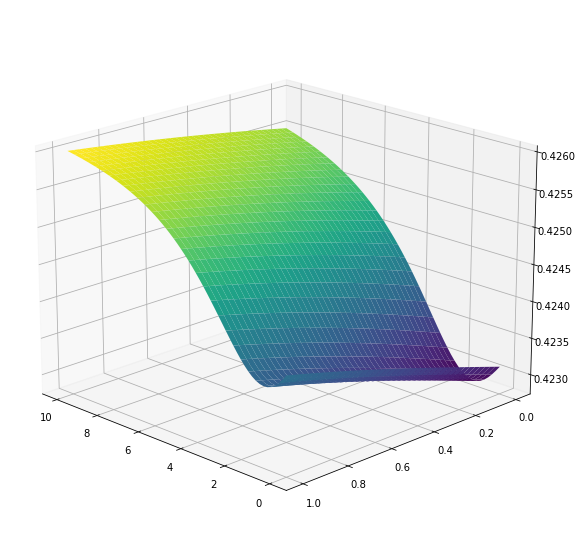

In [ ]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_CNN.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [ ]:
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_CNN.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  2.13800495e-01   1.35
00020  1.04194309e-01   1.83
00040  4.56563874e-02   2.59
00060  1.38067961e-02   3.20
00080  1.11938519e-02   3.79
00100  1.00729566e-02   4.39
00120  9.47180498e-03   4.98
00140  9.08070055e-03   5.55
00160  8.80300379e-03   6.14
00180  8.58823743e-03   6.83
00200  8.40637491e-03   7.60
00220  8.23797797e-03   8.22
00240  8.07333256e-03   8.78
00260  7.91075982e-03   9.33
00280  7.75056686e-03   9.89
00300  7.59251001e-03   10.44
00320  7.43601726e-03   10.99
00340  7.27983718e-03   11.56
00360  7.12164746e-03   12.11
00380  6.95838744e-03   12.66
00400  6.78707203e-03   13.21
00420  6.60764731e-03   13.76
00440  6.64972073e-03   14.34
00460  6.30268327e

In [ ]:
# print('End with L-BFGS-B algorithm')
# coarse = False

# #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
# #solver._updateData(X_r, X_0, X_l, X_u)
# if coarse:
#     ret = solver_CNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
#                                      'maxfun': 50000,
#                                      'maxcor': 50,
#                                      'maxls': 50,
#                                      'ftol': 1e-12})
# else:
#     ret = solver_CNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
#                                      'maxfun': 50000,
#                                      'maxcor': 50,
#                                      'maxls': 50,
#                                      'ftol': 1.0*np.finfo(float).eps})
# print(ret.message)

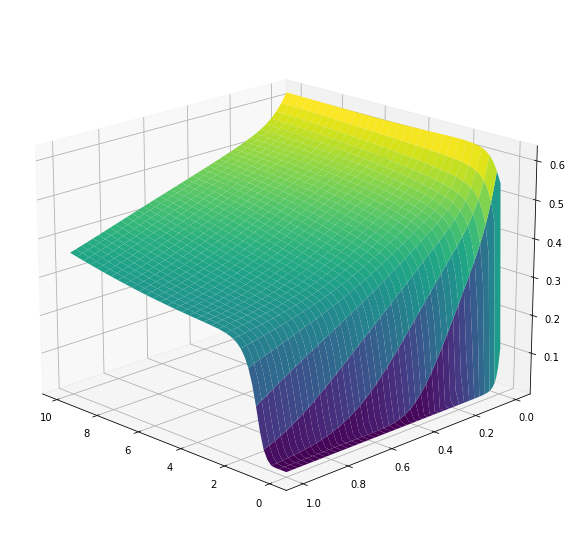

In [ ]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_CNN.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# ResNet CNN

In [ ]:
# gPINN_ResNet_CNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'ResNetCNN')
# N_0 = 1000
# N_b = 1000
# N_r = 4000
# X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
# solver_ResNet_CNN = graphPINNSolver(gPINN_ResNet_CNN, X_r, X_0, X_l, X_u)
# X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

# Recurrent Neural Network

In [ ]:
gPINN_RNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'RNN')
N_0 = 1000
N_b = 1000
N_r = 4000
solver_RNN = graphPINNSolver(gPINN_RNN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 1 neural nets.


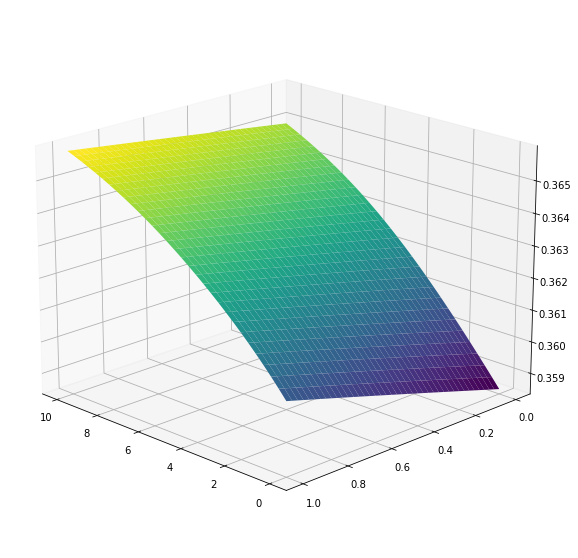

In [ ]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_RNN.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [ ]:
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_RNN.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  1.79259773e-01   13.07
00020  5.24247150e-02   15.54
00040  3.61059117e-02   18.80
00060  1.29921406e-02   21.80
00080  8.84338496e-03   24.81
00100  7.43602189e-03   27.87
00120  6.49441855e-03   31.22
00140  6.68243615e-03   34.47
00160  5.04929062e-03   37.58
00180  4.65900940e-03   40.59
00200  3.88015840e-03   43.64
00220  4.02304345e-03   47.42
00240  3.27965519e-03   51.43
00260  3.03327027e-03   54.76
00280  2.76992839e-03   57.99
00300  2.60771870e-03   60.99
00320  2.49028317e-03   64.03
00340  2.40292620e-03   67.26
00360  2.33648426e-03   70.28
00380  2.28424357e-03   73.31
00400  2.45471711e-03   76.32
00420  2.34498948e-03   79.31
00440  2.24658873e-03   82.47
004

In [ ]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver_RNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver_RNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  1.93274506e-03   3.85
02040  1.92278061e-03   7.07
02060  1.91239717e-03   10.57
02080  1.90517767e-03   13.97
02100  1.89679691e-03   17.06
02120  1.89070221e-03   20.15
02140  1.88277629e-03   23.27
02160  1.87607710e-03   27.18
02180  1.85816398e-03   30.75
02200  1.84646004e-03   34.01
02220  1.82653482e-03   38.00
02240  1.74841439e-03   42.80
02260  1.68152606e-03   46.56
02280  1.50106783e-03   50.05
02300  1.17169202e-03   53.81
02320  9.65584139e-04   57.05
02340  9.01935651e-04   60.52
02360  8.50007313e-04   64.04
02380  8.02923571e-04   67.31
02400  7.61988820e-04   70.68
02420  6.97426928e-04   74.10
02440  6.47727229e-04   77.89
02460  5.92161413e-04   81.56
02480  5.52644681e-04   85.12
02500  5.04625534e-04   88.50
02520  4.61924175e-04   91.89
02540  4.19648189e-04   95.29
02560  3.56090267e-04   98.97
02580  3.33121968e-04   102.39
02600  2.89902483e-04   105.67
02620  2.655

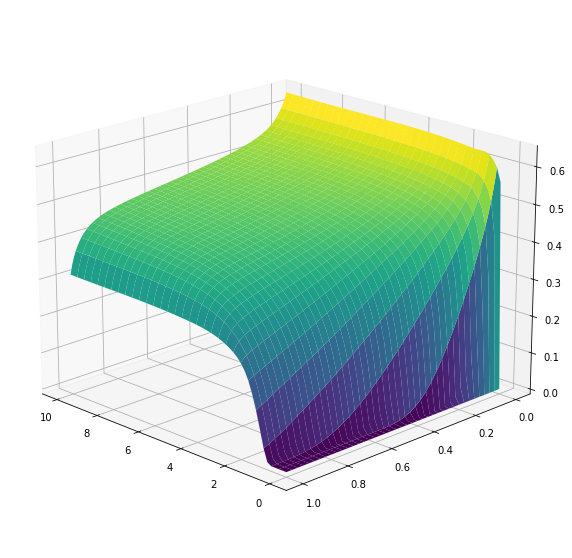

In [ ]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_RNN.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# FVM

In [ ]:
xth_frame = 5
# Time discretization of FVM
nt = N_b * xth_frame
# Spatial discretization of FVM
nx = N_0 + 1

graph_FVM = graph.Example0()
graph_FVM.buildGraph()

fvm_solver = QuantumGraphSolverFVM(graph_FVM)
u_fvm = fvm_solver.solve(nx=nx, nt=nt)

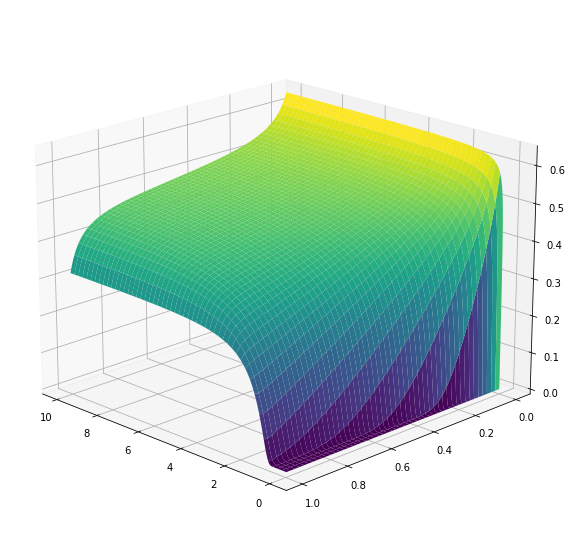

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

t_fvm = [i * 1./500. for i in range(np.shape(u_fvm)[1])]
x_fvm = [i / nx for i in range(np.shape(u_fvm)[0])]

T, X = tf.meshgrid(t_fvm, x_fvm[:999])
ax.plot_surface(T, X, u_fvm[:999, :], cmap='viridis')
ax.view_init(19, 135)

# Comparsion

In [ ]:
Eidx = 0
T, X = tf.meshgrid(t_fvm, x_fvm[:999])
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U_FNN = solver.graphPINN.NNs[Eidx](TX) 
U_FNN = tf.reshape(U_FNN, T.shape)
U_ResNet = solver_ResNet.graphPINN.NNs[Eidx](TX) 
U_ResNet = tf.reshape(U_ResNet, T.shape)
U_CNN = solver_CNN.graphPINN.NNs[Eidx](TX) 
U_CNN = tf.reshape(U_CNN, T.shape)
U_RNN = solver_RNN.graphPINN.NNs[Eidx](TX) 
U_RNN = tf.reshape(U_RNN, T.shape)

In [ ]:
print(u_fvm.shape)
print(U_ResNet.shape)
print(U_FNN.shape)
print(U_CNN.shape)
print(U_RNN.shape)

(1001, 5000)
(999, 5000)
(999, 5000)
(999, 5000)
(999, 5000)


In [ ]:
print(tf.linalg.norm(U_FNN - u_fvm[:999, :]))
print(tf.linalg.norm(U_ResNet - u_fvm[:999, :]))
print(tf.linalg.norm(U_CNN - u_fvm[:999, :]))
print(tf.linalg.norm(U_RNN - u_fvm[:999, :]))

tf.Tensor(10.68787329087826, shape=(), dtype=float64)
tf.Tensor(103.534996052732, shape=(), dtype=float64)
tf.Tensor(94.59166124239376, shape=(), dtype=float64)
tf.Tensor(18.152794231325803, shape=(), dtype=float64)


In [ ]:
print(np.max(tf.abs(U_FNN - u_fvm[:999, :])))
print(np.max(tf.abs(U_ResNet - u_fvm[:999, :])))
print(np.max(tf.abs(U_CNN - u_fvm[:999, :])))
print(np.max(tf.abs(U_RNN - u_fvm[:999, :])))

0.22164611868163664
0.1393647110560542
0.18098532850231627
0.3065629841158833


In [ ]:
input_shape = (100, 1, 2)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv1D(23, 1, activation='sigmoid')(x)
print(y.shape)

(100, 1, 23)


# Stuff

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

x_train = tf.random.normal((100,2))

model = Sequential()


model.add(LSTM(128, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='sigmoid'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
x_train = tf.random.normal((100, 1, 2))
model(x_train)

<tf.Tensor: shape=(100, 1), dtype=float64, numpy=
array([[0.29931463],
       [0.29933342],
       [0.29937818],
       [0.29924348],
       [0.29943498],
       [0.29934156],
       [0.29921004],
       [0.29932094],
       [0.29921997],
       [0.29932439],
       [0.29924587],
       [0.29928465],
       [0.29926715],
       [0.29934491],
       [0.29935956],
       [0.29929608],
       [0.29924464],
       [0.29931211],
       [0.29925442],
       [0.2994091 ],
       [0.29925964],
       [0.29926969],
       [0.29929473],
       [0.29917234],
       [0.29935983],
       [0.29932027],
       [0.29928674],
       [0.29933559],
       [0.29935591],
       [0.29927243],
       [0.29931317],
       [0.29929265],
       [0.29935274],
       [0.29930638],
       [0.29921002],
       [0.29915673],
       [0.29925141],
       [0.2992906 ],
       [0.29931101],
       [0.29931224],
       [0.29934236],
       [0.29945616],
       [0.29925522],
       [0.29917949],
       [0.2993079 ],
     

In [ ]:
# inputs = tf.random.normal([32, 10, 8])
inputs = tf.random.normal((100,2))
inputs = tf.reshape(inputs, (100, 1, 2))


lstm = tf.keras.layers.LSTM(128)
output = lstm(inputs)
print(output.shape)

lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
print(whole_seq_output.shape)

print(final_memory_state.shape)

print(final_carry_state.shape)


(100, 128)
(100, 1, 4)
(100, 4)
(100, 4)
